## Imports

In [112]:
# Import Python libraries for data manipuation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics 

# Import the Python machine learning libraries we need
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Import some convenience functions. 
from functions import *

## Read in Data

In [93]:
train = pd.read_csv('Desktop/home-credit-default-risk/application_train.csv')
test = pd.read_csv('Desktop/home-credit-default-risk/application_test.csv')

## Prepare data

In [94]:
# Replace anomalous values
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


## Feature engineering


In [95]:

# ratio features - create new variables based on existing variables
train['CI_ratio'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']        # credit-to-income ratio
train['AI_ratio'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']       # annuity-to-income ratio
train['GI_ratio'] = train['AMT_GOODS_PRICE'] / train['AMT_INCOME_TOTAL']         # credit to goods price ratio - how much was financed?


# log features - reduce the dynamic range of variables so the differences between them are preserved
train['log_INCOME'] = np.log(train['AMT_INCOME_TOTAL'])                    # log of income
train['log_ANNUITY'] = np.log(train['AMT_ANNUITY'])                        # log of annuity
train['log_CREDIT'] = np.log(train['AMT_CREDIT'])                          # log of credit
train['log_GOODS'] = np.log(train['AMT_GOODS_PRICE'])                      # log of goods

# flag features
train['MissingBureau'] = train.iloc[:, 41:44].isnull().sum(axis=1).astype("category")   # number of bureaus with no score
train['FLAG_CG_ratio'] = train['AMT_CREDIT'] > train['AMT_GOODS_PRICE']                 # FLAG if you borrowed more than the price of the item

# EXT_SOURCE_x variables are very important - let's not leave missing values up to the imputer!
# Instead of imputing missing values by column mean or median, let's fill in missing values by row
# i.e. missing scores are replaced with the average of the scores we do have. If there are no scores at all
# let's just give them a value of 0.2 for now.
train['AVG_EXT'] = train.iloc[:, 41:44].sum(axis=1)/(3- train.iloc[:,41:44].isnull().sum(axis=1))   # average of the (at most) three scores
train['AVG_EXT'].replace(np.nan, 0.2, inplace = True)   # get rid of any /0 errors generated from previous step

train.EXT_SOURCE_1.fillna(train.AVG_EXT, inplace=True)
train.EXT_SOURCE_2.fillna(train.AVG_EXT, inplace=True)
train.EXT_SOURCE_3.fillna(train.AVG_EXT, inplace=True)

train.drop(['AVG_EXT'], axis = 1)   # let's not make AVG_EXT a feature - it will be too highly correlated to the three components

# drop these variables based on poor feature significance (< 0.0001)
train.drop(['REG_REGION_NOT_LIVE_REGION','AMT_REQ_CREDIT_BUREAU_WEEK','HOUSETYPE_MODE','OCCUPATION_TYPE','FLAG_MOBIL','FLAG_CONT_MOBILE',
           'NAME_TYPE_SUITE', 'FLAG_DOCUMENT_4','ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_16',
           'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'AMT_REQ_CREDIT_BUREAU_DAY',
           'AMT_REQ_CREDIT_BUREAU_HOUR', 'FLAG_DOCUMENT_21','FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_17','FLAG_DOCUMENT_2'],
           axis=1, inplace=True)

## Split data into train data and test data

In [96]:
# Todo
# Instead of splitting data - use test files

# Random forest classification


In [97]:
y = train['TARGET'].values
X_train, X_valid, y_train, y_valid = train_test_split(train.drop(['TARGET', 'SK_ID_CURR'], axis = 1), y, stratify = y, test_size=0.8, random_state=1)
print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)
print('Shape of X_valid:',X_valid.shape)
print('Shape of y_valid:',y_valid.shape)

Shape of X_train: (61502, 103)
Shape of y_train: (61502,)
Shape of X_valid: (246009, 103)
Shape of y_valid: (246009,)


## Transform Data - Impute, Scale, One Hot Encode for categorial columns

In [98]:
types = np.array([z for z in X_train.dtypes])        # array([dtype('float64'), dtype('float64'), dtype('O'), dtype('O') ...])
all_columns = X_train.columns.values                 # list of all column names
is_num = types != 'object'                           # returns array([False, False, False, False,  True,  True, ...) where True is a numeric variable
num_features = all_columns[is_num].tolist()          # list of all numeric columns
cat_features = all_columns[~is_num].tolist()         # list of all categorical columns

print(len(num_features), "numeric features")
print(len(cat_features), "categorical features")

92 numeric features
11 categorical features


In [99]:
features = num_features + cat_features

Pipe_num = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'median')),        # tried median, mean, constant strategies
    ('scaler', StandardScaler())       ])

Pipe_cat = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Unknown')),
    ('onehot', OneHotEncoder())        ])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', Pipe_num, num_features),
        ('cat', Pipe_cat, cat_features)])

preprocessor.fit(train[features])
X_train = preprocessor.transform(X_train[features])
X_valid = preprocessor.transform(X_valid[features])


print('Shape of X_train:',X_train.shape)
print('Shape of y_train:',y_train.shape)

Shape of X_train: (61502, 144)
Shape of y_train: (61502,)


## Build models

In [100]:
## DecisionTree
model_dt = DecisionTreeClassifier(random_state = 1)
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [101]:
predictions_dt = model_dt.predict(X_valid)
print("DecisionTreeClassifier", accuracy_score(y_valid, predictions_dt))

DecisionTreeClassifier 0.8499567089008939


In [102]:
## LogisticRegression
model_lr = LogisticRegression(max_iter=2000, solver = 'lbfgs', multi_class='auto')
model_lr.fit(X_train, y_train)



LogisticRegression(max_iter=2000)

In [103]:
predictions_lr = model_lr.predict(X_valid)
print("LogisticRegression", accuracy_score(y_valid, predictions_lr))

LogisticRegression 0.9191614940916796


## Evaluate the model

In [122]:
# Todo 
# Confusion matrix 
matrix_dt = confusion_matrix(y_valid, predictions_dt, labels=[1,0])
matrix_lr = confusion_matrix(y_valid, predictions_lr, labels=[1,0])


# Precision score

precision_dt = precision_score(y_valid, predictions_dt, average = 'binary')
precision_lr = precision_score(y_valid, predictions_lr, average = 'binary')

# Recall Score

recall_dt = precision_score(y_valid, predictions_dt, average = 'binary')
recall_lr = precision_score(y_valid, predictions_lr, average = 'binary')

# F1 Score

f1_dt = precision_score(y_valid, predictions_dt, average = 'binary')
f1_lr = precision_score(y_valid, predictions_lr, average = 'binary')

print('Decision Tree Classifier: \n')
print('Confusion Matrix\n', matrix_dt, '\n')
print('Precision Score', precision_dt, '\n')
print('Recall Score', recall_dt, '\n')
print('F1 Score', f1_dt, '\n')

print('Logistic Regression: \n')
print('Confusion Matrix \n', matrix_lr, '\n')
print('Precision Score', precision_lr, '\n')
print('Recall Score', recall_lr, '\n')
print('F1 Score', f1_lr, '\n')


Decision Tree Classifier: 

Confusion Matrix
 [[  3258  16602]
 [ 20310 205839]] 

Precision Score 0.13823828920570264 

Recall Score 0.13823828920570264 

F1 Score 0.13823828920570264 

Logistic Regression: 

Confusion Matrix 
 [[   245  19615]
 [   272 225877]] 

Precision Score 0.4738878143133462 

Recall Score 0.4738878143133462 

F1 Score 0.4738878143133462 



In [105]:
# DecisionTreeClassifier
print('DecisionTreeClassifier %.4f' % accuracy_score(y_valid, predictions_dt))

# LogisticRegression
print('LogisticRegression %.4f' % accuracy_score(y_valid, predictions_lr))

DecisionTreeClassifier 0.8500
LogisticRegression 0.9192


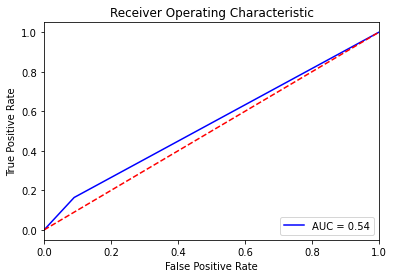

In [106]:
# ROC Curve - DecisionTreeClassifier

fpr, tpr, threshold = metrics.roc_curve(y_valid, predictions_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.xlim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


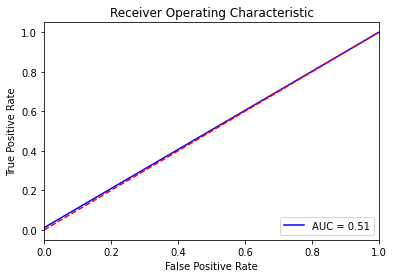

In [107]:
# ROC Curve - LogisticRegression

fpr, tpr, threshold = metrics.roc_curve(y_valid, predictions_lr)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.xlim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



In [108]:
# Todo
# Share code in Github
print(roc_auc_score(y_valid, predictions_lr))

0.5055668038098935


In [109]:
missing_values_table(train).head(20)

Your selected dataframe has 105 columns.
There are 62 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
FLOORSMIN_AVG,208642,67.8


In [110]:
missing_values_table(train).head(20)

Your selected dataframe has 105 columns.
There are 62 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
FLOORSMIN_AVG,208642,67.8
